In [55]:
using Distributions
using Plots
using AdaptiveSurveillance

In [6]:
const L = 3
const output_path = joinpath(dirname(pathof(AdaptiveSurveillance)), "..", "results", "tmp")
const ν = 1 / 21 # approx 6 months until there is an outbreak
const Γd = [Geometric(ν) for l = 1:L]
const p0 = 0.01
const β = 4e-6 * 536 * 7
const p = prevalance_sequence(p0[1], β)
const n = 200

200

In [2]:
α = 1000 # the higher, the less false positives

1000

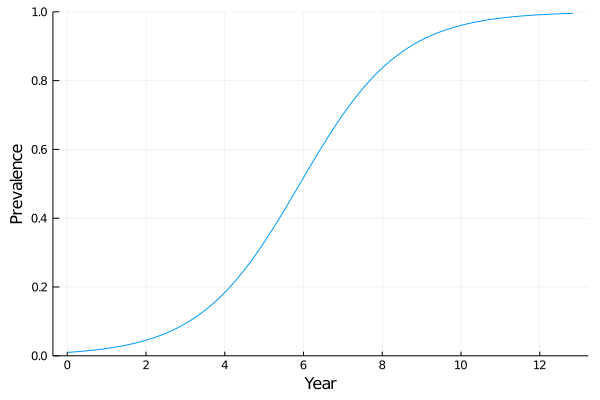

In [10]:
T = length(p)
plot((1:T)./52, p, ylim=(0, 1), legend=false, xlabel = "Year", ylabel = "Prevalence")

In [11]:
# Delay for different thresholds
println(length(p[p .<= 2 * p0]))
println(length(p[p .<= 3 * p0]))
println(length(p[p .<= 5 * p0]))
println(length(p[p .<= 0.10]))

47
75
110
160


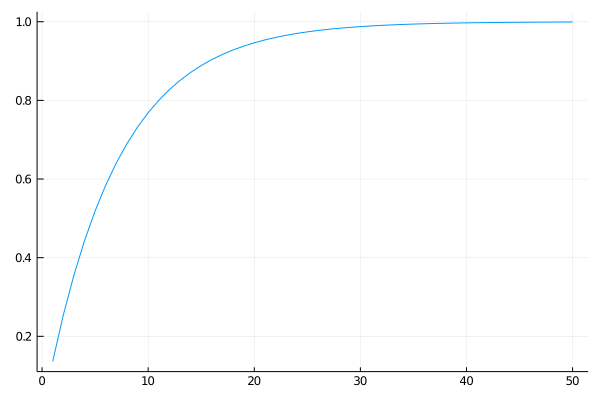

In [17]:
Γd_all = Geometric(1 - prod(1 .- succprob.(Γd)))
plot(1:50, cdf.(Γd_all, 0:(49)), legend = false)

In [21]:
apolicy_constant_p(L, Γd, n, α, test_data, t) = apolicy_constant(L, Γd, n, α, test_data, t, apolicy_isotonic, 1)

apolicy_constant_p (generic function with 1 method)

In [27]:
# Debug
t, la, false_alarm, delay, test_data, z, thres = replication(L, Γd, [10, 0, 0], p0, p, n, apolicy_constant_p, α, 
    tpolicy_constant, 1);

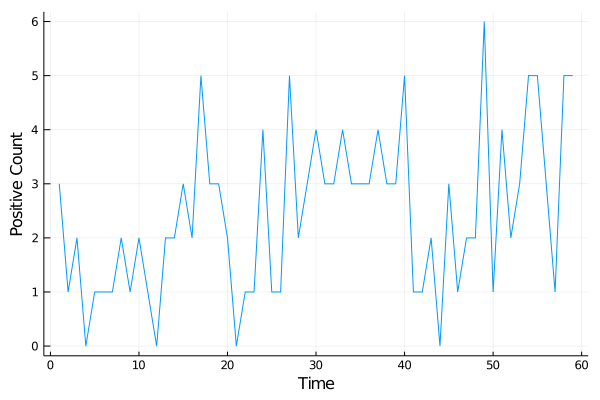

In [29]:
plot(1:(t-1), test_data[1:(t-1), 1], xlabel = "Time", ylabel = "Positive Count", legend=false)

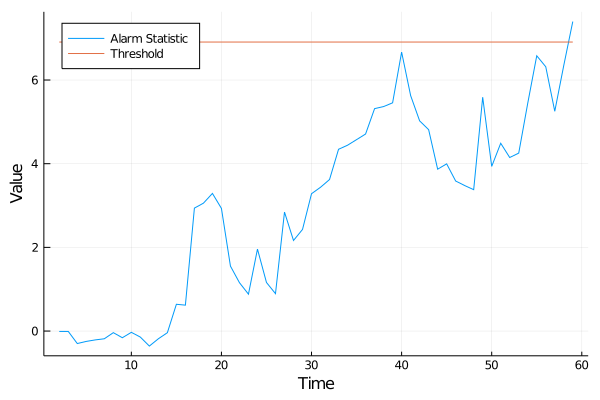

In [30]:
plot(2:(t-1), hcat(z[3:t], thres[3:t]), xlabel = "Time", ylabel = "Value", label = ["Alarm Statistic" "Threshold"],
legend=:topleft)

In [45]:
# Alarm time distribution
atd_T = 200
atd_0 = alarm_time_distribution(Int(1e4), L, Γd, [0, 0, 0], p0, p, n, apolicy_constant_p, α, 
    tpolicy_constant, 1, maxiters=atd_T);
atd_0 = cumsum(atd_0) ./ sum(atd_0);

In [46]:
atd_1 = alarm_time_distribution(Int(1e4), L, Γd, ones(Int64, L) * typemax(Int64), p0, p, n, apolicy_constant_p, α, 
    tpolicy_constant, 1, maxiters=atd_T);
atd_1 = cumsum(atd_1) ./ sum(atd_1);

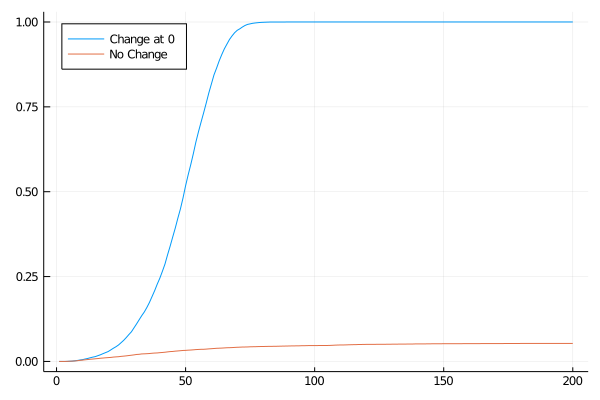

In [47]:
plot(1:atd_T, hcat(atd_0[1:atd_T], atd_1[1:atd_T]), label = ["Change at 0" "No Change"], legend=:topleft)

In [48]:
# Predictive Value - I cannot get this to work for multiple locations yet
# pvt = sp_single.predictive_value(Int(1e4), 21, 52, Γd, p0, p, n, sp_single.apolicy_isotonic, α);
#alarm_counts, atl, pvt = predictive_value_ratio(1e-3, 52, L, Γd, p0, p, n, apolicy_constant_p, α, 
#    tpolicy_constant, 1, miniters=Int(1e4))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN])

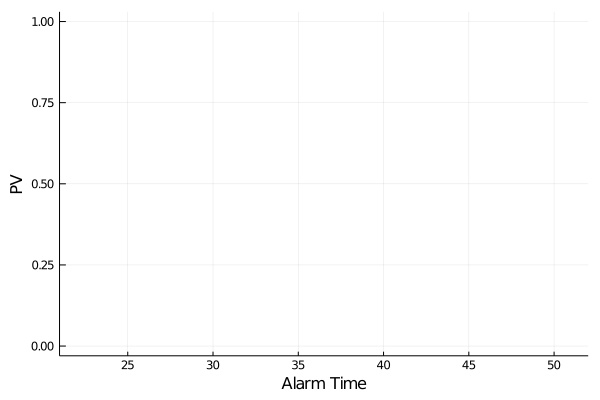

In [49]:
# plot(pvt, xlabel = "Alarm Time", ylabel = "PV", legend=false, xlim=(21, 52))

In [58]:
# Probability of successful detection
T_end = 21
sp2 = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, Γd, p0, p, n, apolicy_constant_p, α,
    tpolicy_constant, 1);
sp3 = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, Γd, p0, p, n, apolicy_constant_p, α,
    tpolicy_constant, 1);
sp5 = probability_successfull_detection_l(Int(1e4), T_end, 110, 1, L, Γd, p0, p, n, apolicy_constant_p, α,
    tpolicy_constant, 1);

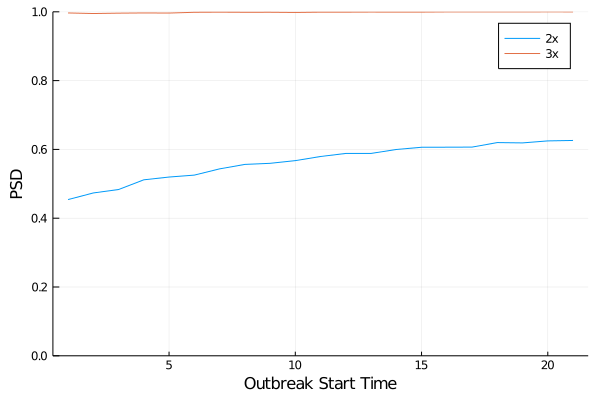

In [59]:
plot(1:T_end, hcat(sp2, sp3), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))